# This colab is used to load rosbag and make a perception with Mask-Rcnn and can store into hdf5 , image topic type of bag can be sensor/Image or sensor/CompressedImage.

# Install ROS

In [19]:
%%bash
sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'
apt-key adv --keyserver 'hkp://keyserver.ubuntu.com:80' --recv-key C1CF6E31E6BADE8868B172B4F42ED6FBAB17C654
apt update  &> /dev/null
apt install ros-melodic-ros-base &> /dev/null

sudo rosdep init  &> /dev/null
rosdep update  &> /dev/null

apt install python-rosinstall  &> /dev/null
apt install python-catkin-tools  &> /dev/null
apt install ros-melodic-ros-numpy ros-melodic-vision-opencv &> /dev/null

Executing: /tmp/apt-key-gpghome.9k3jh0nXH4/gpg.1.sh --keyserver hkp://keyserver.ubuntu.com:80 --recv-key C1CF6E31E6BADE8868B172B4F42ED6FBAB17C654


gpg: key F42ED6FBAB17C654: "Open Robotics <info@osrfoundation.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1


In [1]:
import sys
import os
import time

sys.path.append('/opt/ros/melodic/lib/python2.7/dist-packages/')
print(sys.path)

os.environ['PATH'] += ':/opt/ros/melodic/bin'
print(os.environ['PATH'])

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/opt/ros/melodic/lib/python2.7/dist-packages/']
/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/opt/ros/melodic/bin


In [21]:
!pip install rospkg
!pip install pycryptodomex
!pip install gnupg

In [2]:
import re
import math
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import rosbag
import h5py
import ros_numpy
from sensor_msgs.msg import Image, PointCloud2, PointField
from cv_bridge import CvBridge, CvBridgeError
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Get immage from bag and store in list

In [3]:
def get_image_list(height,weight,channels,bag_path,topic):
  imgs = []
  b = rosbag.Bag(bag_path,'r')
  for topic, msg, t in b.read_messages(topic):
      img = ros_numpy.image.image_to_numpy(msg)
      img = cv2.resize(img, (weight, height), interpolation=cv2.INTER_AREA)
      imgs.append(img)
  return imgs

Read image from hdf5 and store to list

In [4]:
def read_img(path):
    f = h5py.File(path,'r')
    img_st = []
    for key in f.keys():
       print(key)
       print(f[key].name)
       print(f[key].shape)
       img_st.append(f[key].value)
    return img_st

Input image list and write to hdf5

In [5]:
def write_hdf5(image,outfile):
    with h5py.File(outfile,'w') as f:      
        f['image'] = image

Prepare bag file

Example of sensor/Image

In [ ]:
import gdown
%cd /content/
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id=1zCMv2-eSARCszz-ZvxmljvbEfrfJ62RD&export=download'
dataset_name = 'rosbag'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)

print("Finished downloading dataset.")

/content
/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1zCMv2-eSARCszz-ZvxmljvbEfrfJ62RD&export=download
To: /content/bags/rosbag.bag
1.58GB [00:10, 146MB/s]


Finished downloading dataset.


Example of sensor/CompressedImage

In [ ]:
path = '1L_VF3Cw1MzvKOUV6f2SDVMbVpJQr392T'

In [ ]:
import gdown
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id='+path+'&export=download'
dataset_name = 'a_lvl_2_split'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)

print("Finished downloading dataset.")

/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1L_VF3Cw1MzvKOUV6f2SDVMbVpJQr392T&export=download
To: /content/bags/a_lvl_2_split.bag
663MB [00:04, 152MB/s]


Finished downloading dataset.


In [ ]:
Bag_path = '/content/bags'

In [ ]:
bags = os.listdir(Bag_path)[::-1]
bags.sort()

Show rosbag informations

In [ ]:
for b_name in bags:
  if b_name != '.ipynb_checkpoints':
    print(rosbag.Bag(Bag_path+'/'+b_name))

If bag doesn't contain sensor/Image but sensor/CompressedImage , use this function to do converting compressedImage to image.

In [16]:
bag_path = '/content/bags/a_lvl_2_split.bag'
topic = '/chinook/multisense/left/image_rect_color/compressed'

In [ ]:
bag_path = '/content/bags/a_lvl_2_split.bag'
topic = '/sherman/multisense/left/image_rect_color/compressed'

In [6]:
def readImage(topic_name,bag_path):  
    bag  = rosbag.Bag(bag_path)
    lis = []

    bridge = CvBridge()

    for topic, msg, t in bag.read_messages(topics=topic_name):
        try:
            np_arr = np.fromstring(msg.data, np.uint8)
            cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
            lis.append(cv_image)
        except CvBridgeError as e:
            print('e')
    return lis

create hdf5 of topic

In [ ]:
temp = readImage(topic,bag_path)
!rm rf '/content/compressdimage_data.hdf5'
write_hdf5(np.array(temp),'/content/compressdimage_data.hdf5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


rm: cannot remove 'rf': No such file or directory
rm: cannot remove '/content/compressdimage_data.hdf5': No such file or directory


read hdf5 file

In [ ]:
output_file = '/content/compressdimage_data.hdf5'
compressed_Img = read_img(output_file)

image
/image
(301, 544, 1024, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


randomly show

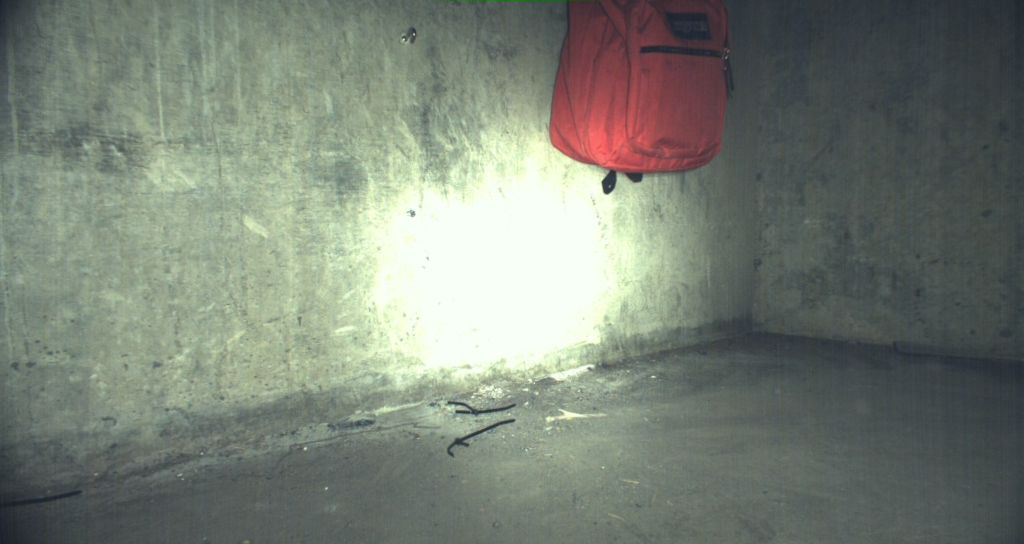

In [ ]:
compressed_image_list = np.array(compressed_Img)
cv2_imshow(compressed_image_list[0][200])

If bag contain sensor/Image.

In [ ]:
bag_path = '/content/bags/rosbag.bag'
topic = '/camera/color/image_raw'

create hdf5 of topic

In [ ]:
Image = get_image_list(256,256,3,bag_path,topic)
write_hdf5(Image,'/content/Image_data.hdf5')

read hdf5 file

In [ ]:
output_file = '/content/Image_data.hdf5'
Img = read_img(output_file)

randomly show

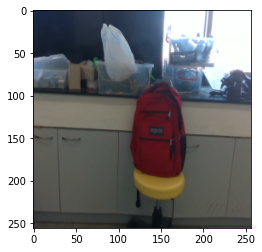

In [ ]:
image_list = np.array(Img)
plt.imshow(image_list[0][0])

Define MaskRcnn model

In [28]:
import sys
%cd /content
!git clone https://github.com/ARG-NCTU/Mask-RCNN-Detectron2.git
sys.path.append('/content/Mask-RCNN-Detectron2')

/content
fatal: destination path 'Mask-RCNN-Detectron2' already exists and is not an empty directory.


In [ ]:
!pip install -U git+https://github.com/facebookresearch/fvcore.git
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [7]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os 
import gdown
import torch
import logging
from zipfile import ZipFile

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [8]:
import numpy as np
import struct
import math
import time
import rospkg
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import os 

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [9]:
dataset_url = 'https://drive.google.com/u/1/uc?id=1qjaXe4h7TM0SYeq_i9MLSbPaiciex6bV&export=download'
dataset_name = 'subt_new'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
    zip1 = ZipFile('/content/subt_new' + '.zip')
    zip1.extractall('/content/subt_new')
    zip1.close()

print("Finished downloading dataset.")

Finished downloading dataset.


In [10]:
register_coco_instances('subt_val', {}, 
								'/content/subt_new/subt_new/test.json', 
							'/content/subt_new/subt_new/subt_test')

In [11]:
path = ''
subt_metadata = MetadataCatalog.get("subt_val")
dataset_dicts = DatasetCatalog.get("subt_val")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = os.path.join('/content/output/model_0096989.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Download model

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
models_url = "https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1bQcS2kjlchaoL6_xd8keeIxk9QNNt3xO&export=download"
models_name = "model_0096989.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.")

Downloading...
From: https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1bQcS2kjlchaoL6_xd8keeIxk9QNNt3xO&export=download
To: /content/output/model_0096989.pth
351MB [00:04, 73.9MB/s]


Finished downloading models.


In [12]:
predictor = DefaultPredictor(cfg)

Run perception

In [13]:
def perception(data):
  Result = []
  coord = np.zeros((1,544,1024))
  num = data.shape[1]
  for i in range(num):
    outputs = predictor(data[0][i])
    # print('1')
    v = Visualizer(data[0][i][:, :, ::-1],
					  metadata=subt_metadata,
					  scale=0.8, 
				  #	 instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
		  )
    # print('1')
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # print('1')
    temp = outputs["instances"].pred_masks.cpu().numpy()
    # print('1')
    # temp = temp.squeeze(axis=0)
    # coord = np.concatenate((coord,temp),axis=0)
    # coord = (outputs["instances"].pred_masks.cpu().numpy())
    # if coord.size != 0:
    #   print(coord.shape)
    # print(coord)
    result = v.get_image()[:, :, ::-1]
    # print('1')
    print('Frame : ',i,'\n')
    Result.append(result)
    plt.figure(figsize=(15,15))
    plt.imshow(result[:,:,[2,1,0]])
    plt.show()
    # cv2_imshow(result)
  # coord = coord.astype('int32')
  return Result

Image bag

In [ ]:
result_1 = perception(image_list)

compressed image bag

In [26]:
path = '1qjgPagtAyKFw_NWVvV331quQ7Oc5ZP5P'
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id='+path+'&export=download'
dataset_name = 'a_lvl_2_split'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)
temp = readImage(topic,bag_path)
!rm rf '/content/compressdimage_data.hdf5'
write_hdf5(np.array(temp),'/content/compressdimage_data.hdf5')
output_file = '/content/compressdimage_data.hdf5'
compressed_Img = read_img(output_file)
compressed_image_list = np.array(compressed_Img)

/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1qjgPagtAyKFw_NWVvV331quQ7Oc5ZP5P&export=download
To: /content/bags/a_lvl_2_split.bag
700MB [00:12, 57.1MB/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


rm: cannot remove 'rf': No such file or directory
image
/image
(300, 544, 1024, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [27]:
result_2 = perception(compressed_image_list)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
%mkdir -p /content/ex_B1_phone
%cd /content/ex_B1_phone
j = 0
for i in range(0,37):
  # if (i ==201) or (i ==204):
  #   print('skip ',i)
  # else:
    cv2.imwrite('exB1_phone_'+str(j)+'.jpg', compressed_image_list[0][i])
    j += 1
print(j)

/content/ex_B1_phone
37


In [29]:
!zip -r '/content/ex_B1_phone.zip' '/content/ex_B1_phone'
from google.colab import files
files.download("/content/ex_B1_phone.zip")

  adding: content/ex_B1_phone/ (stored 0%)
  adding: content/ex_B1_phone/exB1_phone_36.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_32.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_34.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_30.jpg (deflated 3%)
  adding: content/ex_B1_phone/exB1_phone_15.jpg (deflated 3%)
  adding: content/ex_B1_phone/exB1_phone_10.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_27.jpg (deflated 3%)
  adding: content/ex_B1_phone/exB1_phone_18.jpg (deflated 3%)
  adding: content/ex_B1_phone/exB1_phone_8.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_28.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_22.jpg (deflated 3%)
  adding: content/ex_B1_phone/exB1_phone_6.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_9.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_1.jpg (deflated 4%)
  adding: content/ex_B1_phone/exB1_phone_3.jpg (deflated 4%)
  adding: content/ex_B1_phone/ex

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
!zip -r '/content/ex_B1_phone.zip' '/content/ex_B1_phone'
from google.colab import files
files.download("/content/ex_B1_phone.zip")

  adding: content/ex_B1_survivor/ (stored 0%)
  adding: content/ex_B1_survivor/exB1_survivor_67.jpg (deflated 5%)
  adding: content/ex_B1_survivor/exB1_survivor_655.jpg (deflated 13%)
  adding: content/ex_B1_survivor/exB1_survivor_493.jpg (deflated 9%)
  adding: content/ex_B1_survivor/exB1_survivor_553.jpg (deflated 9%)
  adding: content/ex_B1_survivor/exB1_survivor_541.jpg (deflated 9%)
  adding: content/ex_B1_survivor/exB1_survivor_37.jpg (deflated 5%)
  adding: content/ex_B1_survivor/exB1_survivor_41.jpg (deflated 5%)
  adding: content/ex_B1_survivor/exB1_survivor_498.jpg (deflated 9%)
  adding: content/ex_B1_survivor/exB1_survivor_444.jpg (deflated 9%)
  adding: content/ex_B1_survivor/exB1_survivor_34.jpg (deflated 5%)
  adding: content/ex_B1_survivor/exB1_survivor_371.jpg (deflated 4%)
  adding: content/ex_B1_survivor/exB1_survivor_479.jpg (deflated 9%)
  adding: content/ex_B1_survivor/exB1_survivor_356.jpg (deflated 4%)
  adding: content/ex_B1_survivor/exB1_survivor_510.jpg (defl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Store result to hdf5

In [ ]:
cv2_imshow(result_2[227])

In [ ]:
write_hdf5(result_1,'/content/result_maskrcnn__1.hdf5')

In [ ]:
write_hdf5(result_2,'/content/result_maskrcnn_survivor.hdf5')

read hdf5

In [ ]:
output_file_ = '/content/result_1.hdf5'
result_ = read_img(output_file_)

image
/image
(1029, 204, 204, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [ ]:
output_file = '/content/result_maskrcnn_survivor.hdf5'
result__ = read_img(output_file)

image
/image
(300, 435, 819, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


show image

In [ ]:
for i in range(300):
  print(i)
  cv2_imshow(result__[0][i])

Output hidden; open in https://colab.research.google.com to view.

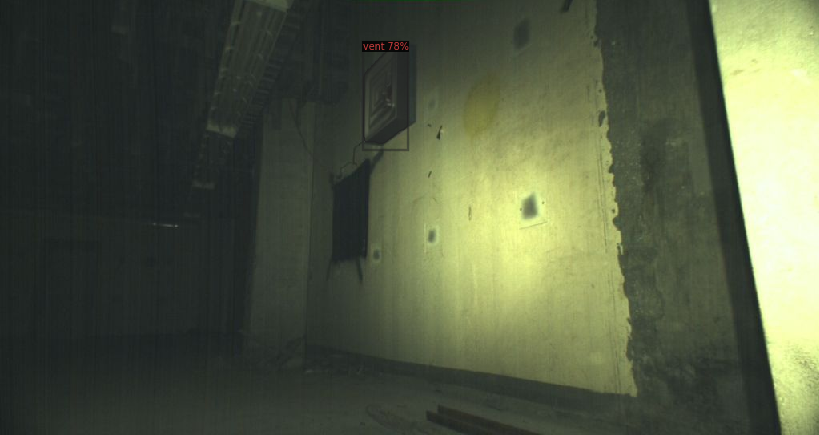

In [ ]:
cv2_imshow(result__[0][260])